In [1]:
%reload_kedro

2022-01-06 18:23:10,071 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-01-06 18:23:10,103 - root - INFO - ** Kedro project Kedro Classification
2022-01-06 18:23:10,104 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-01-06 18:23:10,115 - root - INFO - Registered line magic `run_viz`


In [97]:
import numpy as np
import bisect
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils.validation import check_is_fitted
from pandas import DataFrame
from logging import getLogger
from sklearn.model_selection import train_test_split

class InductiveConformalPredictor():
    """
    Standard Conformal Predictor with uncertainty non-conformity score.
    Args:
        predictor: classifier used in upstream task.

    FROM: https://medium.com/data-from-the-trenches/measuring-models-uncertainty-with-conformal-prediction-f6aa8debb50e
    """

    def __init__(self, predictor):
        self.predictor = predictor
        check_is_fitted(self.predictor, attributes=["classes_"])

        self._le = LabelEncoder()
        self.classes = self._le.fit_transform(predictor.classes_)

    def fit(self, X, y):
        self.calibration_score = self._uncertainty_conformity_score(X)
        self.calibration_class = self._le.transform(y)
        return self

    def _uncertainty_conformity_score(self, data):
        uncertainty_score = 1 - self.predictor.predict_proba(data)
        return uncertainty_score

    def predict_proba(self, X, mondrian=True):
        check_is_fitted(self, attributes=["calibration_score"])

        conformity_score = self._uncertainty_conformity_score(X)
        conformal_pred = np.zeros(conformity_score.shape)

        for c in self.classes:
            if mondrian:
                calibration_filt = self.calibration_score[self.calibration_class == c]
                calib = calibration_filt[:, c]
            else:
                calib = self.calibration_score[range(len(self.calibration_class)), 
                                                          self.calibration_class]

            sorted_calib = np.sort(calib)
            conformal_pred[:, c] = [float(bisect.bisect(sorted_calib, x))/len(calib)
                                    for x in conformity_score[:, c]]

        return conformal_pred

    def predict(self, X, mondrian=True, alpha=0.05):
        _conformal_proba = self.predict_proba(X=X, mondrian=mondrian)
        conformal_pred = (_conformal_proba > alpha).astype(int)

        mlb = MultiLabelBinarizer()
        mlb.fit([self._le.classes_])
        pred = mlb.inverse_transform(conformal_pred)

        return pred




def return_conformity_scores(
    data, params, model
) -> DataFrame:
    cfm = InductiveConformalPredictor(predictor=model)

    X, Y = data[params.get('features')], data[params.get('target')]

    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.20, random_state=42)

    cfm.fit(X_train, y_train)

    y_test_conf = cfm.predict(X, alpha=0.30)

    data = data.copy()

    data['y_test_conf'] = y_test_conf 
    
    return data

In [98]:
data_test = catalog.load('scored_test')
model = catalog.load('model')

d2 = return_conformity_scores(data_test, context.params, model)

2022-01-06 18:54:02,553 - kedro.io.data_catalog - INFO - Loading data from `scored_test` (CSVDataSet)...
2022-01-06 18:54:02,601 - kedro.io.data_catalog - INFO - Loading data from `model` (PickleDataSet)...


In [99]:
d2.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_44,col_45,col_46,col_47,col_48,col_49,prob,pred,target,y_test_conf
0,-3.493173,-0.509165,-2.582468,-0.509165,0.013374,1.975392,-1.093144,0.061589,-2.950694,1.995767,...,-2.951339,0.607983,-0.273420,0.640315,-3.084249,-0.702677,0.03,0,0,"(0, 1)"
1,-0.788008,-1.276801,1.805202,-1.276801,0.595913,-1.021949,2.170628,0.718320,-0.996668,-3.058386,...,1.982549,-0.498727,0.567667,1.828288,0.085496,-2.379323,0.07,0,0,"(0, 1)"
2,2.171439,3.854353,-0.648804,3.854353,-1.332176,-1.651561,0.074379,1.072888,-0.758293,2.600717,...,2.778934,-0.617083,1.296409,0.216893,-0.681378,-1.898457,0.01,0,0,"(1,)"
3,-6.153759,-1.546545,3.992382,-1.546545,3.782450,-0.064498,-0.577700,-0.866840,0.137411,-0.970860,...,-0.040117,-1.089560,-0.100761,1.157891,-0.183256,-0.329543,0.03,0,0,"(0, 1)"
4,-6.880897,1.639963,-1.215717,1.639963,0.723222,0.495791,0.343391,2.245995,-1.183659,4.695544,...,-1.693624,0.195847,-0.454965,-0.169131,-5.171496,-3.370625,0.09,0,0,"(0, 1)"


In [100]:
d2.y_test_conf.value_counts()

(0, 1)    1249
(1,)       416
(0,)        85
Name: y_test_conf, dtype: int64

In [101]:
d2.groupby(['y_test_conf'])['prob'].agg([max, min])

,max,min
y_test_conf,,
"(0,)",0.96,0.75
"(0, 1)",0.74,0.02
"(1,)",0.01,0.00


In [105]:
!pip install matplotlib

     |████████████████████████████████| 11.2 MB 521 kB/s            
     |████████████████████████████████| 4.3 MB 520 kB/s            
  Using cached kiwisolver-1.3.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
     |████████████████████████████████| 890 kB 487 kB/s            


2022-01-06 18:56:00,239 - matplotlib.font_manager - INFO - generated new fontManager


ValueError: setting an array element with a sequence.

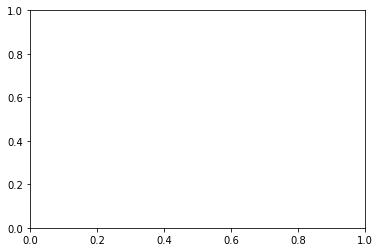

In [106]:
import matplotlib.pyplot as plt

plt.scatter(x=d2.prob, y=d2.y_test_conf)

In [60]:
d2

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_44,col_45,col_46,col_47,col_48,col_49,prob,pred,target,conformity
0,-3.493173,-0.509165,-2.582468,-0.509165,0.013374,1.975392,-1.093144,0.061589,-2.950694,1.995767,...,-2.951339,0.607983,-0.273420,0.640315,-3.084249,-0.702677,0.03,0,0,0.97
1,-0.788008,-1.276801,1.805202,-1.276801,0.595913,-1.021949,2.170628,0.718320,-0.996668,-3.058386,...,1.982549,-0.498727,0.567667,1.828288,0.085496,-2.379323,0.07,0,0,0.93
2,2.171439,3.854353,-0.648804,3.854353,-1.332176,-1.651561,0.074379,1.072888,-0.758293,2.600717,...,2.778934,-0.617083,1.296409,0.216893,-0.681378,-1.898457,0.01,0,0,0.99
3,-6.153759,-1.546545,3.992382,-1.546545,3.782450,-0.064498,-0.577700,-0.866840,0.137411,-0.970860,...,-0.040117,-1.089560,-0.100761,1.157891,-0.183256,-0.329543,0.03,0,0,0.97
4,-6.880897,1.639963,-1.215717,1.639963,0.723222,0.495791,0.343391,2.245995,-1.183659,4.695544,...,-1.693624,0.195847,-0.454965,-0.169131,-5.171496,-3.370625,0.09,0,0,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745,-3.695467,-0.763730,-0.827646,-0.763730,-1.502020,-0.044763,-0.424226,-0.205949,0.550007,2.592384,...,-1.008205,1.119700,-0.622156,-0.142041,0.601776,-1.128011,0.07,0,0,0.93
1746,-4.396225,0.121039,0.299888,0.121039,1.376245,-0.242528,-1.040712,2.036360,0.532742,3.469761,...,-2.638298,0.368279,-0.464371,0.934308,0.095304,-3.078514,0.23,0,1,0.77
1747,1.069875,2.636306,-1.787460,2.636306,-1.570729,0.039470,-0.815778,0.462548,0.272153,3.236305,...,4.528864,0.469858,0.652905,-0.769284,-2.246664,-1.203302,0.00,0,0,1.00
1748,-1.881053,-0.329345,0.677922,-0.329345,1.670595,0.215662,-0.531323,1.702387,-2.352691,-1.243938,...,0.380434,-0.462927,0.325791,0.236856,-1.971024,-0.387244,0.03,0,0,0.97
